In [1]:
import json
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from app.data_ingestion.data_utils import DataUtils

sns.set()
sns.set_palette("viridis")

In [24]:
data_dir = os.path.abspath(os.path.join(".", "cs-train"))
print('DATA PATH: {}'.format(data_dir))

DATA PATH: C:\workspace\ai-workflow-capstone\cs-train


In [7]:
data_handler = DataUtils()
invoices_df_ts = data_handler.load_all_json_files(data_dir)\
                          .convert_to_dataframe(output=False)\
                          .convert_dataframe_to_ts(index_column="date")\
                          #.make_features_to_ts()

In [5]:
data_handler._invoices_df_ts

,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
date,,,,,,
2017-11-01,0,0,0,0,2017-11,0.00
2017-11-02,0,0,0,0,2017-11,0.00
2017-11-03,0,0,0,0,2017-11,0.00
2017-11-04,0,0,0,0,2017-11,0.00
2017-11-05,0,0,0,0,2017-11,0.00
...,...,...,...,...,...,...
2019-06-26,1358,67,999,6420,2019-06,4903.17
2019-06-27,1620,80,944,9435,2019-06,5499.38
2019-06-28,1027,70,607,5539,2019-06,3570.60


In [6]:
from app.data_ingestion.data_repository import DataRepository

repository = DataRepository()
repository.connect_db().insert(data_handler._invoices_df_ts)

In [3]:
from app.data_ingestion.data_repository import DataRepository

repository = DataRepository()
df = repository.connect_db().list()
df

,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
date,,,,,,
2017-11-01,0,0,0,0,2017-11,0.00
2017-11-02,0,0,0,0,2017-11,0.00
2017-11-03,0,0,0,0,2017-11,0.00
2017-11-04,0,0,0,0,2017-11,0.00
2017-11-05,0,0,0,0,2017-11,0.00
...,...,...,...,...,...,...
2019-06-26,1358,67,999,6420,2019-06,4903.17
2019-06-27,1620,80,944,9435,2019-06,5499.38
2019-06-28,1027,70,607,5539,2019-06,3570.60


In [6]:
data_handler = DataUtils().make_features_to_ts(dataframe=df)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## Which country had the most total revenue when you summed across all purchases?

## When you compiled the JSON files into a single DataFrame or NumPy array, about how many days did the entire range of dates span?

In [22]:
invoices_df_ts_by_day = invoices_df_ts.resample('D').max()
print('{} unique days'.format(len(invoices_df_ts_by_day)))

611 unique days


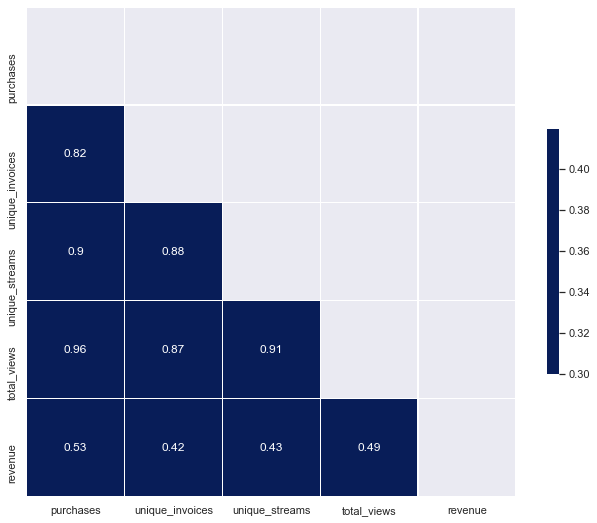

In [11]:
# Compute the correlation matrix
corr = data_handler._invoices_df_ts.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='YlGnBu', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

## Revenue Time Series Decompositon

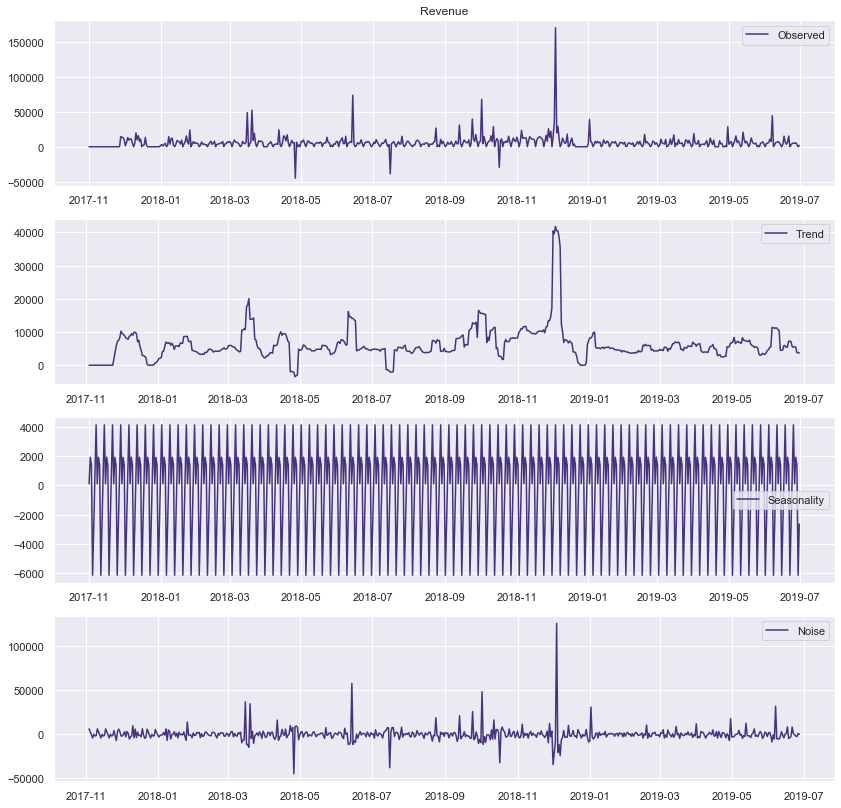

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts = data_handler._invoices_df_ts.resample('1D').mean()['revenue'].fillna(1)
decomposition = seasonal_decompose(x=ts, model='additive', ) # 1 weeks

trend = decomposition.trend
seasonal = decomposition.seasonal
noise = decomposition.resid

plt.figure(figsize=(14,14))
plt.subplot(411)
plt.title('Revenue')
plt.plot(ts, label='Observed')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(noise, label='Noise')
plt.legend(loc='best')


ax = plt.show()

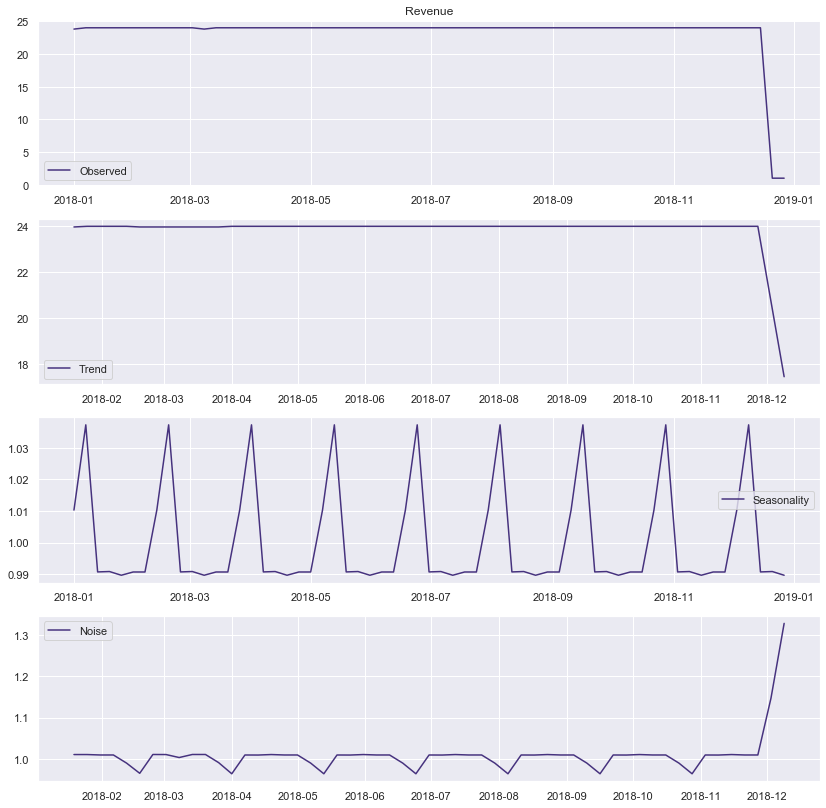

In [77]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts = invoices_df_ts_by_day['2018'].resample('6D').mean()['times_viewed'].fillna(1)
decomposition = seasonal_decompose(x=ts, model='multiplicative') # 1 weeks

trend = decomposition.trend
seasonal = decomposition.seasonal
noise = decomposition.resid

plt.figure(figsize=(14,14))
plt.subplot(411)
plt.title('Revenue')
plt.plot(ts, label='Observed')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(noise, label='Noise')
plt.legend(loc='best')


ax = plt.show()

In [67]:
invoices_df_ts_by_day.resample('M').max()['times_viewed']

ts
2017-11-30    24.0
2017-12-31    24.0
2018-01-31    24.0
2018-02-28    24.0
2018-03-31    24.0
2018-04-30    24.0
2018-05-31    24.0
2018-06-30    24.0
2018-07-31    24.0
2018-08-31    24.0
2018-09-30    24.0
2018-10-31    24.0
2018-11-30    24.0
2018-12-31    24.0
2019-01-31    24.0
2019-02-28    24.0
2019-03-31    24.0
2019-04-30    24.0
2019-05-31    24.0
2019-06-30    24.0
2019-07-31    24.0
Freq: M, Name: times_viewed, dtype: float64

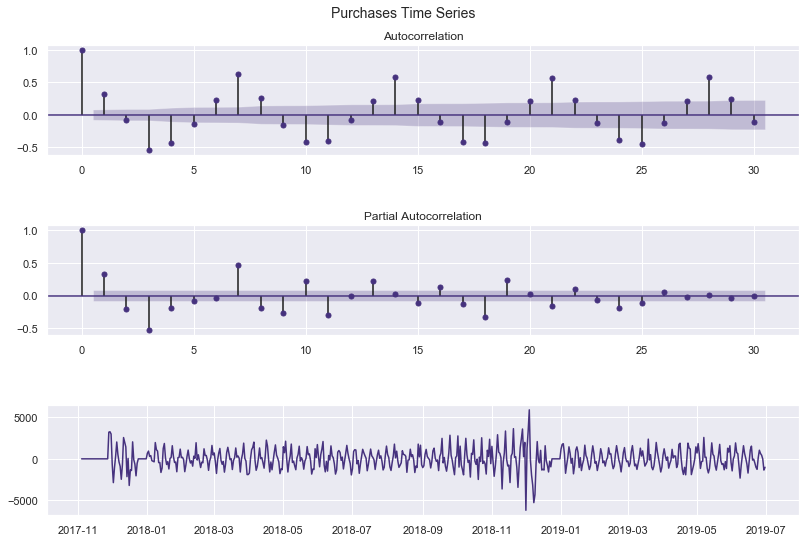

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Stationary data

ts = data_handler._invoices_df_ts['purchases']

fig, ax = plt.subplots(3, figsize=(12,8))
x = (ts.dropna() - ts.dropna().shift(3)).dropna()
ax[0] = plot_acf(x, ax=ax[0], lags=30)
ax[1] = plot_pacf(x, ax=ax[1], lags=30)
ax[2].plot(x)

fig.suptitle("Purchases Time Series", fontsize=14)
fig.tight_layout(pad=3.0)
fig.show()

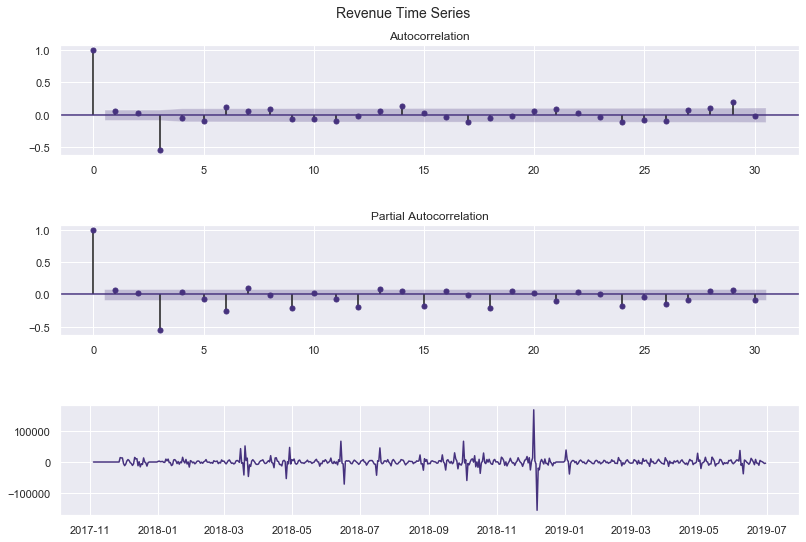

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Stationary data

ts = data_handler._invoices_df_ts['revenue']

fig, ax = plt.subplots(3, figsize=(12,8))
x = (ts.dropna() - ts.dropna().shift(3)).dropna()
ax[0] = plot_acf(x, ax=ax[0], lags=30)
ax[1] = plot_pacf(x, ax=ax[1], lags=30)
ax[2].plot(x)

fig.suptitle("Revenue Time Series", fontsize=14)
fig.tight_layout(pad=3.0)
fig.show()

In [88]:
import pandas as pd
import statsmodels.api as sm
from scipy import stats
price = data_handler._invoices_df_ts.set_index('date')['purchases']
times_viewed = invoices_df_ts_by_day['2018'].resample('6D').mean()['times_viewed'].fillna(1)
X = sm.add_constant(price)
model = sm.OLS(times_viewed,X)

results = model.fit()
residual = price.values-results.params[0] - results.params[1]*times_viewed.values

In [89]:
print('p value of Jarque-Bera test is: {}'.format(stats.jarque_bera(residual)[1]))
print('p value of Shapiro-Wilk test is: {}'.format(stats.shapiro(residual)[1]))
print('p value of Kolmogorov-Smirnov test is: {}'.format(stats.kstest(residual, 'norm')[1]))

p value of Jarque-Bera test is: 0.0
p value of Shapiro-Wilk test is: 1.3637284357326251e-10
p value of Kolmogorov-Smirnov test is: 5.737725873848851e-91


In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

price = invoices_df_ts_by_day['2018'].resample('5D').mean()['price'].fillna(1)
times_viewed = invoices_df_ts_by_day['2018'].resample('5D').mean()['times_viewed'].fillna(1)

X = sm.add_constant(times_viewed)
model = sm.OLS(price,X)
results = model.fit()

import statsmodels.stats.api as sms
print('The Durbin-Watson statistic is: {}'.format(sms.durbin_watson(results.resid)))
print('p value of Breusch-Godfrey test is: {}'.format(sms.acorr_breusch_godfrey(results,nlags=1)[3]))

The Durbin-Watson statistic is: 2.0932179078790076
p value of Breusch-Godfrey test is: 0.6832775391383177
